In [28]:
import backtrader as bt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import backtrader as bt
import plotly.graph_objects as go


class MovingAverageCrossStrategy(bt.Strategy):
    params = (
        ("short_ma_period", 20),
        ("long_ma_period", 50),
    )

    def __init__(self):
        self.short_ma = bt.indicators.SMA(self.data.close, period=self.params.short_ma_period)
        self.long_ma = bt.indicators.SMA(self.data.close, period=self.params.long_ma_period)
        self.crossover = bt.indicators.CrossOver(self.short_ma, self.long_ma)

    def next(self):
        if self.position.size == 0:
            if self.crossover > 0:
                self.buy()
        elif self.position.size > 0:
            if self.crossover < 0:
                self.close()

    def generate_signals(self, data):
        # Compute the short and long moving averages
        short_ma = data['Close'].rolling(self.short_ma_period).mean()
        long_ma = data['Close'].rolling(self.long_ma_period).mean()

        # Generate the buy and sell signals
        data['signal'] = 0
        data.loc[short_ma > long_ma, 'signal'] = 1
        data.loc[short_ma < long_ma, 'signal'] = -1

        # Set the signal to 0 if the short and long moving averages are equal
        data.loc[short_ma == long_ma, 'signal'] = 0

        return data




In [29]:
# Download Apple stock data from Yahoo Finance
data = yf.download("AAPL", start="2015-01-01", end="2022-02-23")


[*********************100%***********************]  1 of 1 completed


In [30]:
# Create a cerebro instance and add data feed
cerebro = bt.Cerebro()
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add the strategy
cerebro.addstrategy(MovingAverageCrossStrategy)

# Set the initial capital and commission
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe_ratio")
cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")

# Run the backtest
cerebro.run()




<IPython.core.display.Javascript object>


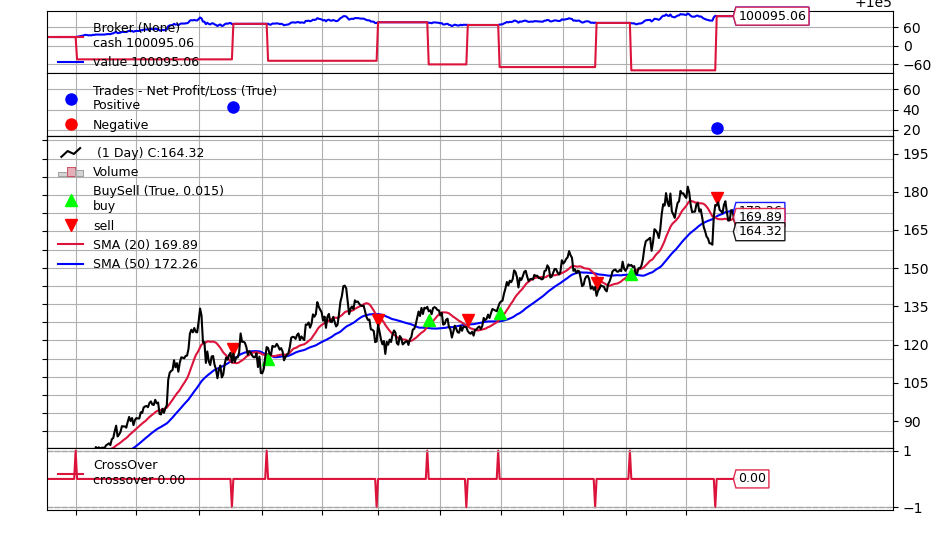

[[<Figure size 640x480 with 5 Axes>]]

In [31]:
cerebro.plot()

In [11]:
results = cerebro.run()

signals = [x.lines.signal[0] for x in results]
prices = [x.lines.close[0] for x in results]

# Create a plotly figure and add the signals and prices
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.datetime.datetime(), y=data.close, name='Close'))
fig.add_trace(go.Scatter(x=data.datetime.datetime(), y=signals, mode='markers', marker=dict(size=7), name='Signals'))
fig.update_layout(title='My Strategy for AAPL', xaxis_title='Date', yaxis_title='Price')
fig.show()

AttributeError: 'Lines_LineSeries_LineIterator_DataAccessor_Strateg' object has no attribute 'signal'

In [6]:
# Print the final portfolio value
print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

Final Portfolio Value: 100095.06
